In [1]:
import sys
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Add src to path
sys.path.append('..')
from src.data_loader import load_dataset
from src.preprocessing import create_text_features, clean_text, stop_words
from src.models import create_advanced_pipeline
from src.visualization import plot_multilabel_confusion
from src.analysis import extract_top_features, print_failure_examples

# 1. Load Data
df_train_full, df_test = load_dataset("../data")
df_train_full = create_text_features(df_train_full)
df_test = create_text_features(df_test)

# 2. Prepare Labels
label_cols = df_train_full.select_dtypes(include=['number']).columns.tolist()
if 'Argument ID' in label_cols: label_cols.remove('Argument ID')
y_train = df_train_full[label_cols].values
y_test = df_test[label_cols].values

# --- CRITICAL FIX: APPLY WINNING PREPROCESSING (Lower + Stopwords + Lemma) ---
print("🧹 Applying winning preprocessing to Train and Test sets...")

def apply_winning_strategy(text):
    text = str(text).lower()
    words = [w for w in text.split() if w not in stop_words]
    text_no_stop = " ".join(words)
    return clean_text(text_no_stop, strategy='lemmatized')

X_train = [apply_winning_strategy(t) for t in df_train_full['text'].values]
X_test = [apply_winning_strategy(t) for t in df_test['text'].values]
# ---------------------------------------------------------------------------

# 3. RECREATE BEST MODEL (From Notebook 03 Results)
best_model_type = "logreg"
best_ngram = (1, 2)
best_C = 0.6871
best_min_df = 5
best_max_features = None

print(f"⏳ Retraining {best_model_type} (C={best_C}, min_df={best_min_df}, N-grams={best_ngram})...")

# Create Pipeline
pipeline = create_advanced_pipeline(model_type=best_model_type, vec_type="tfidf", ngram_range=best_ngram)

# Set Hyperparameters manually to match tuning exactly
pipeline.set_params(
    clf__estimator__C=best_C,
    vec__min_df=best_min_df,
    vec__max_features=best_max_features
)

# Fit on FULL Train+Val
pipeline.fit(X_train, y_train)

print("✅ Model Trained. Generating Predictions on Official Test Set...")
# PREDICT ON THE CLEANED TEST DATA
y_pred = pipeline.predict(X_test)

[nltk_data] Downloading package stopwords to /home/alumno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alumno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alumno/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alumno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


🧹 Applying winning preprocessing to Train and Test sets...
⏳ Retraining logreg (C=0.6871, min_df=5, N-grams=(1, 2))...
✅ Model Trained. Generating Predictions on Official Test Set...


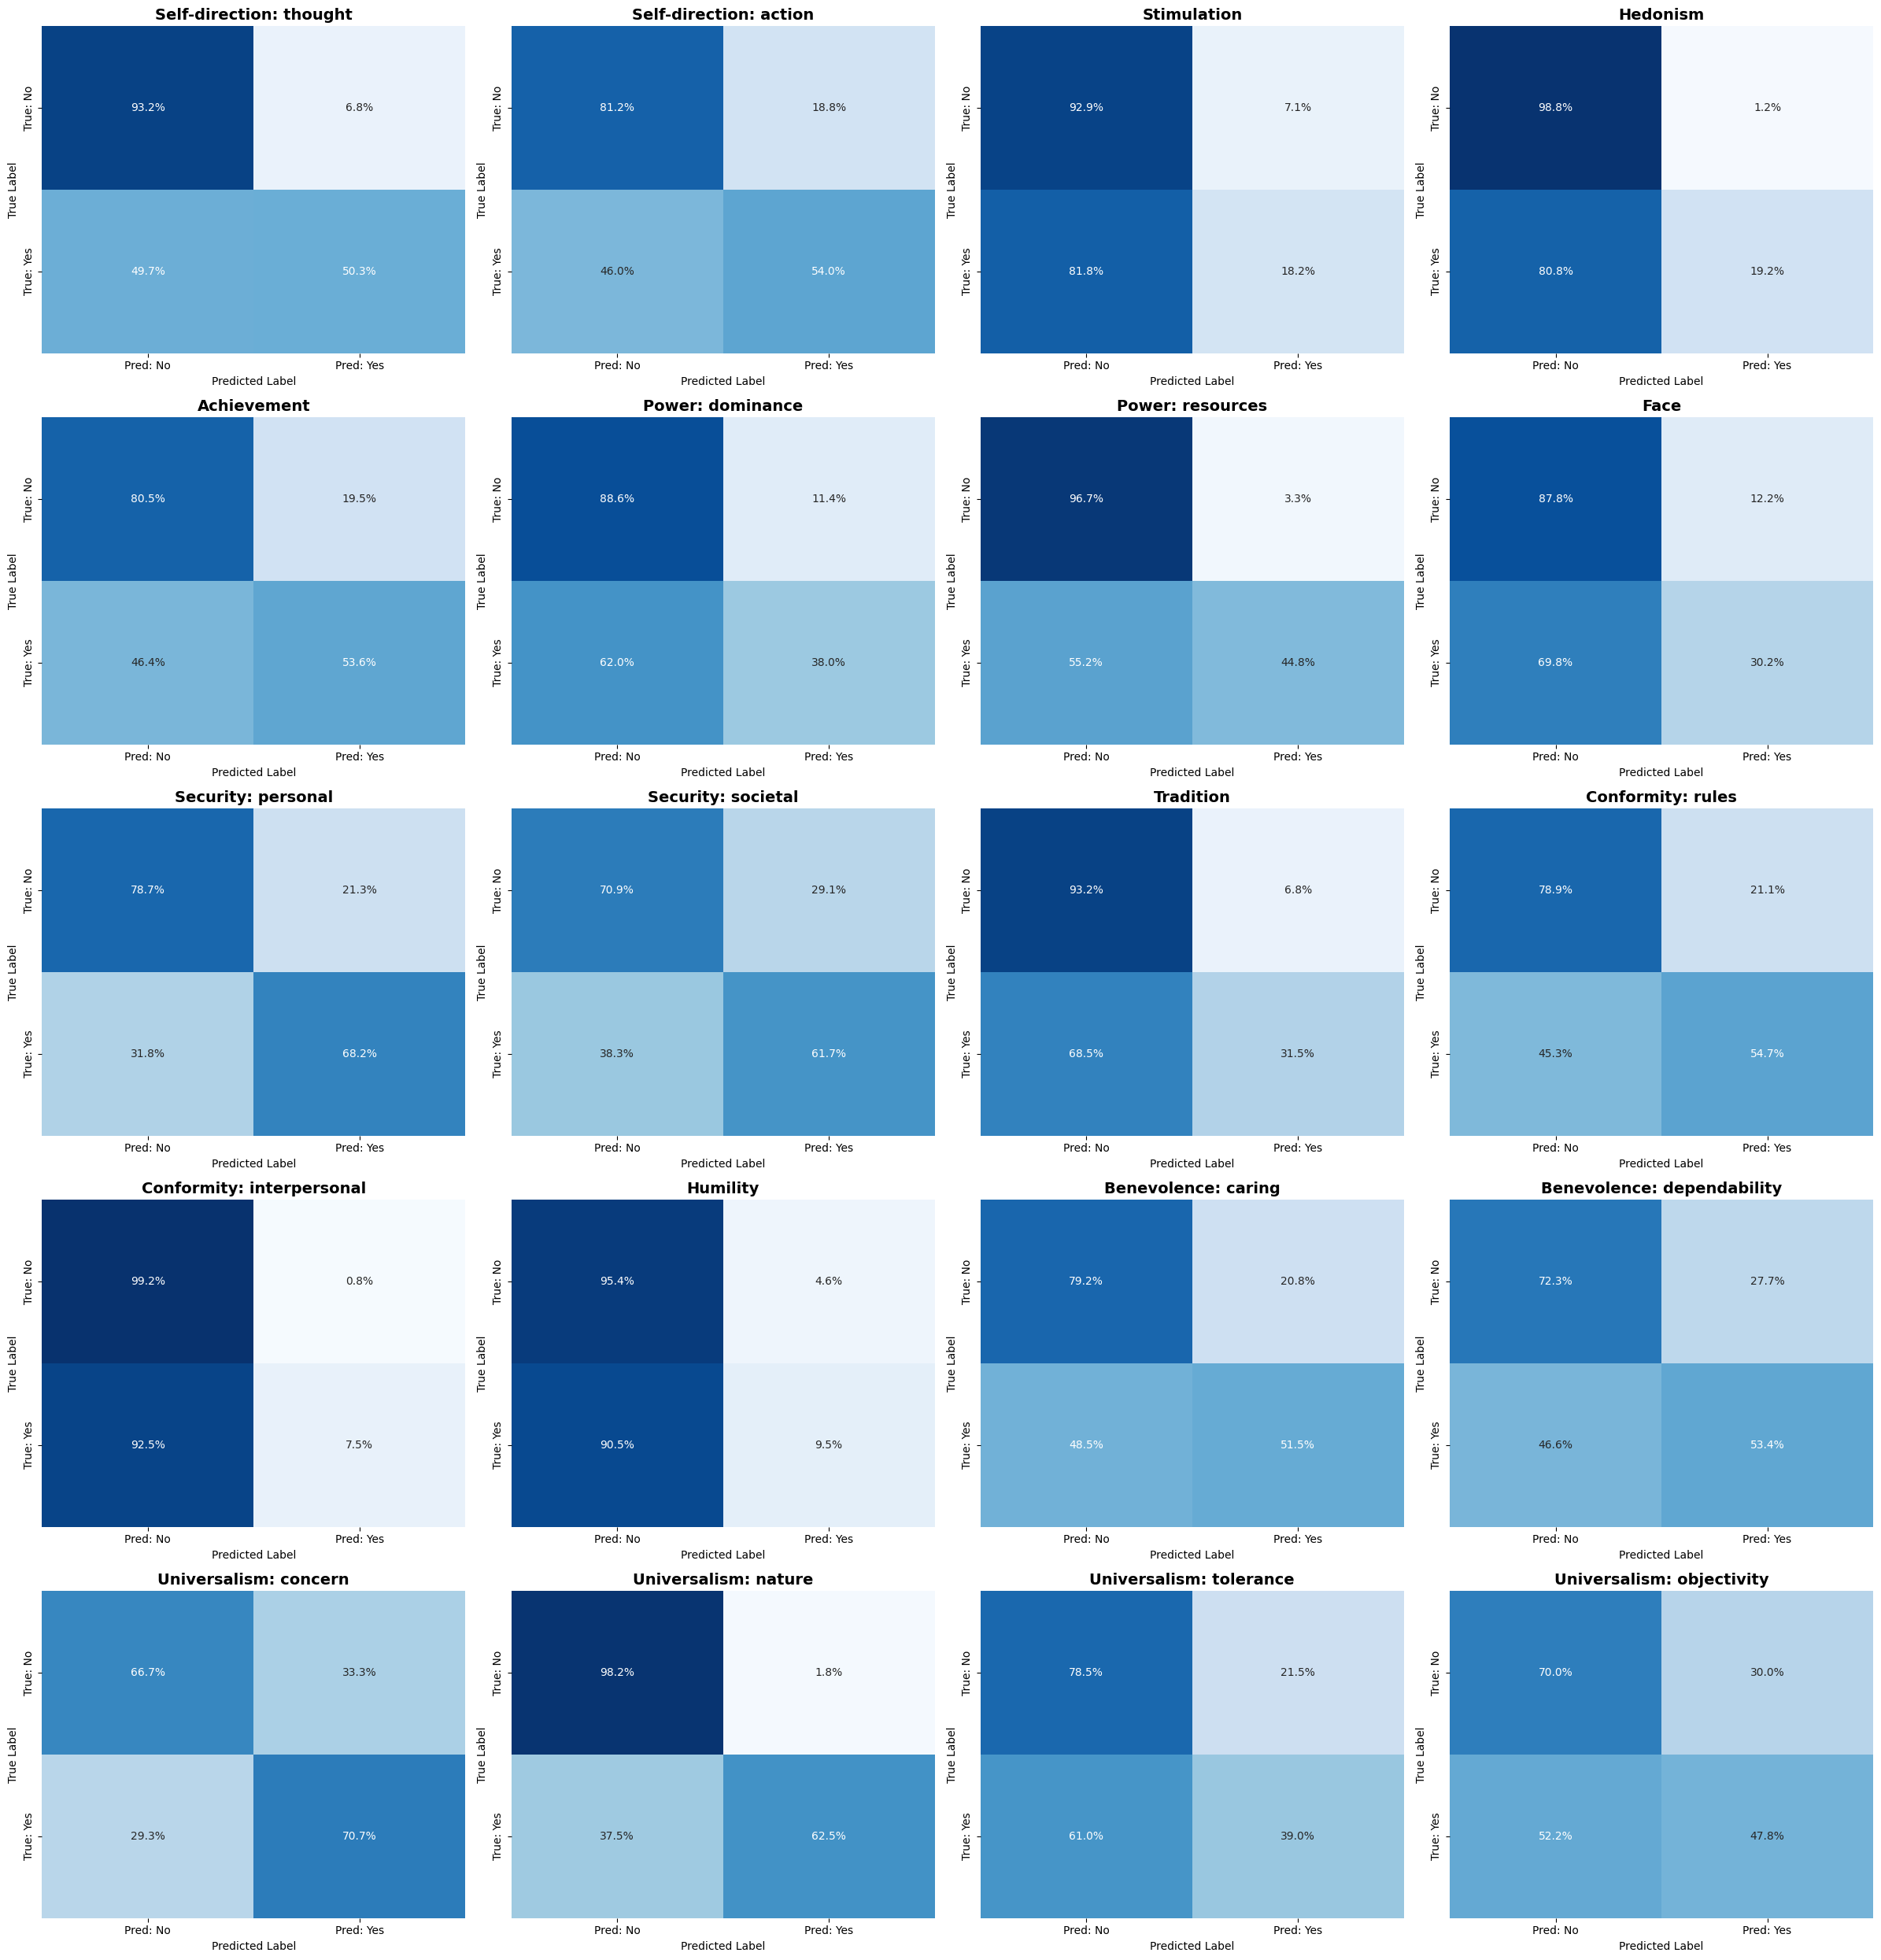

In [2]:
# --- VISUALIZATION: Confusion Matrices ---
# This generates a 20-grid heatmap


plot_multilabel_confusion(y_test, y_pred, label_cols, filename="final_confusion_matrix.png")

In [3]:
# --- INTERPRETATION: Top Features ---
# Which words drive the decision for each value?

extract_top_features(pipeline, label_cols, n=10)


🔍 EXTRACTING DISCRIMINATIVE FEATURES (TOP 10 N-GRAMS)

🏆 CLASS: Self-direction: thought
   🟢 POSITIVE (+): freedom, choice, right, choose, learn, innovation, wikipedia, research, express, speech
   🔴 NEGATIVE (-): offence favor, cause, legalize, whale, kill, clone favor, ban favor, dangerous, surrogacy, foster

🏆 CLASS: Self-direction: action
   🟢 POSITIVE (+): freedom, right, choice, want, free, choose, selection favor, collectivism favor, libertarianism favor, retirement favor
   🔴 NEGATIVE (-): ban favor, favor, offence favor, minor favor, surgery favor, kill, food favor, dangerous, arm favor, voting favor

🏆 CLASS: Stimulation
   🟢 POSITIVE (+): life, people, think, ability, television, abandon, prostitution favor, couple, activity, new
   🔴 NEGATIVE (-): government, whale, law, minor favor, prayer, kill, game favor, surgery favor, loan, protect

🏆 CLASS: Hedonism
   🟢 POSITIVE (+): television, cannabis favor, entertainment, cannabis, abandon favor, abandon, celebrate, everyone, p

In [4]:
# --- QUALITATIVE ANALYSIS: Failure Cases ---
# Look at these examples to write the "Error Analysis" section of your report.

print_failure_examples(X_test, y_test, y_pred, label_cols, n=5)


❌ FOUND 1552 TEXTS WITH ERRORS.
Showing 5 random examples for Qualitative Analysis:

📝 EXAMPLE #1 (Index 1545)
--------------------------------------------------------------------------------
TEXT: aware migration due climate change favor already 84 million climate refugee world number grow every single day! nobody protect tomorrow become one them. need create new law protect climate refugee value human life high value.

🧠 TRUE:      ['Conformity: rules', 'Universalism: concern', 'Universalism: objectivity']
🤖 PREDICTED: ['Power: dominance', 'Conformity: rules', 'Benevolence: caring', 'Universalism: nature', 'Universalism: objectivity']

📝 EXAMPLE #2 (Index 272)
--------------------------------------------------------------------------------
TEXT: ban naturopathy people turn naturopathy turn conventional medicine case, harm allow gain placebo affect here.

🧠 TRUE:      ['Self-direction: action', 'Security: personal']
🤖 PREDICTED: ['Self-direction: action', 'Achievement', 'Security: pe